## This model has the following characteristics:
* No feature engineering
* Applying multiple Conv1Ds to raw transactions

In [5]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#  tf.logging.set_verbosity(tf.logging.ERROR) <- logging이 버전업그레이드에서 사용 X라함

# from tensorflow import set_random_seed 
# 위에 코드 안됨에 대한 답변: In Tensoflow2 there is no need to perform
# from tensorflow import set_random_seed
# in order to run
# set_random_seed(x)
# (as it was in older version)
# Only have to run
# import tensorflow
# tensorflow.random.set_seed(x)

tf.random.set_seed(2020)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.preprocessing.text import *

### Read Data

In [6]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

df_train.head(10)

,cust_id,tran_date,store_nm,goods_id,gds_grp_nm,gds_grp_mclas_nm,amount
0,0,2007-01-19 00:00:00,강남점,127105,기초 화장품,화장품,850000
1,0,2007-03-30 00:00:00,강남점,342220,니 트,시티웨어,480000
2,0,2007-03-30 00:00:00,강남점,127105,기초 화장품,화장품,3000000
3,0,2007-03-30 00:00:00,강남점,342205,니 트,시티웨어,840000
4,0,2007-03-30 00:00:00,강남점,342220,상품군미지정,기타,20000
5,0,2007-05-13 00:00:00,강남점,127105,기초 화장품,화장품,3000000
6,0,2007-05-13 00:00:00,강남점,321101,디자이너부틱,디자이너,11264000
7,0,2007-05-13 00:00:00,강남점,443204,비지니스군,셔츠,975000
8,0,2007-06-09 00:00:00,강남점,9112,유제품,축산가공,85000
9,0,2007-06-09 00:00:00,강남점,72196,건강식품,건강식품,2340000


### Transform Data

In [7]:
#df_train.goods_id.nunique(), df_train.gds_grp_nm.nunique(), df_train.gds_grp_mclas_nm.nunique()
#df_train.store_nm.astype('category').cat.codes
#pd.to_datetime(df_train.tran_date).dt.weekday

max_features = 100000
max_len = 100
emb_dim = 128

##### low level: goods_id

In [8]:
# Converts a "goods_id" to a sequence of indexes in a fixed-size hashing space
df_train.goods_id = df_train.goods_id.apply(lambda x: str(x))
df_test.goods_id = df_test.goods_id.apply(lambda x: str(x))
X_train = df_train.groupby('cust_id')['goods_id'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['goods_id'].apply(lambda x: [one_hot(i, max_features)[0] for i in x]).values

# Pads sequences to the same length
X_train_low = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_low = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_low.shape, X_test_low.shape

((3500, 100), (2482, 100))

##### middle level: gds_grp_nm

In [9]:
# Converts a "gds_grp_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features//10)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_nm'].apply(lambda x: [one_hot(i, max_features//10)[0] for i in x]).values

# Pads sequences to the same length
X_train_mid = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_mid = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_mid.shape, X_test_mid.shape

((3500, 100), (2482, 100))

##### high level: gds_grp_mclas_nm

In [10]:
# Converts a "gds_grp_mclas_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['gds_grp_mclas_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_high = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_high = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_high.shape, X_test_high.shape

((3500, 100), (2482, 100))

##### store

In [11]:
# Converts a "store_nm" to a sequence of indexes in a fixed-size hashing space
X_train = df_train.groupby('cust_id')['store_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values
X_test = df_test.groupby('cust_id')['store_nm'].apply(lambda x: [one_hot(i, max_features//100)[0] for i in x]).values

# Pads sequences to the same length
X_train_str = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_str = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_str.shape, X_test_str.shape

((3500, 100), (2482, 100))

##### weekday

In [12]:
# Converts a "tran_date" to a sequence of indexes in a fixed-size hashing space
df_train.tran_date = pd.to_datetime(df_train.tran_date).dt.weekday
df_test.tran_date = pd.to_datetime(df_test.tran_date).dt.weekday
X_train = df_train.groupby('cust_id')['tran_date'].apply(lambda x: list(x)).values
X_test = df_test.groupby('cust_id')['tran_date'].apply(lambda x: list(x)).values

# Pads sequences to the same length
X_train_day = sequence.pad_sequences(X_train, maxlen=max_len)
X_test_day = sequence.pad_sequences(X_test, maxlen=max_len)

X_train_day.shape, X_test_day.shape

((3500, 100), (2482, 100))

### Build Models

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
low (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
mid (InputLayer)                (None, 100)          0                                            
__________________________________________________________________________________________________
high (InputLayer)               (None, 100)          0                                            
__________________________________________________________________________________________________
store (InputLayer)              (None, 100)          0                                            
____________________________________________________________________________________________

Train on 2800 samples, validate on 700 samples
Epoch 1/50
2800/2800 [==============================] - 9s 3ms/step - loss: 0.7192 - acc: 0.4775 - val_loss: 0.6749 - val_acc: 0.6214
Epoch 2/50
2800/2800 [==============================] - 8s 3ms/step - loss: 0.6631 - acc: 0.6186 - val_loss: 0.6520 - val_acc: 0.6229
Epoch 3/50
2800/2800 [==============================] - 8s 3ms/step - loss: 0.6443 - acc: 0.6232 - val_loss: 0.6426 - val_acc: 0.6229
Epoch 4/50
2800/2800 [==============================] - 9s 3ms/step - loss: 0.6371 - acc: 0.6289 - val_loss: 0.6371 - val_acc: 0.6243
Epoch 5/50
2800/2800 [==============================] - 9s 3ms/step - loss: 0.6297 - acc: 0.6218 - val_loss: 0.6328 - val_acc: 0.6257
Epoch 6/50
2800/2800 [==============================] - 8s 3ms/step - loss: 0.6252 - acc: 0.6432 - val_loss: 0.6284 - val_acc: 0.6300
Epoch 7/50
2800/2800 [==============================] - 8s 3ms/step - loss: 0.6208 - acc: 0.6314 - val_loss: 0.6246 - val_acc: 0.6700
Epoch 8/50
2800

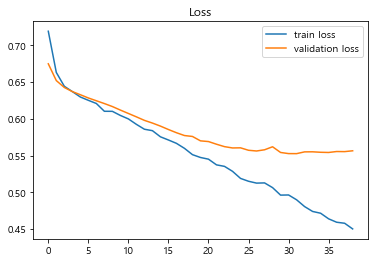

In [13]:
# Define the Model & its Architecture
in_low = Input(shape=(max_len,), dtype='int32', name='low')
x = Embedding(max_features, emb_dim)(in_low)
x = Conv1D(32, 5, activation='elu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(32, 5, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_low = Dropout(0.5)(x)

in_mid = Input(shape=(max_len,), dtype='int32', name='mid')
x = Embedding(max_features//10, emb_dim)(in_mid)
x = Conv1D(32, 3, activation='elu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(32, 3, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_mid = Dropout(0.5)(x)

in_high = Input(shape=(max_len,), dtype='int32', name='high')
x = Embedding(max_features//100, emb_dim)(in_high)
x = Conv1D(32, 1, activation='elu')(x)
x = MaxPooling1D(1)(x)
x = Conv1D(32, 1, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_high = Dropout(0.5)(x)

in_str = Input(shape=(max_len,), dtype='int32', name='store')
x = Embedding(max_features//100, emb_dim)(in_str)
x = Conv1D(32, 1, activation='elu')(x)
x = MaxPooling1D(1)(x)
x = Conv1D(32, 1, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_str = Dropout(0.5)(x)

in_day = Input(shape=(max_len,), dtype='int32', name='day')
x = Embedding(7, emb_dim)(in_day)
x = Conv1D(32, 1, activation='elu')(x)
x = MaxPooling1D(1)(x)
x = Conv1D(32, 1, activation='elu')(x)
x = GlobalMaxPooling1D()(x)
out_day = Dropout(0.5)(x)

x = add([out_low, out_mid, out_high, out_str, out_day], name='my_layer')
out = Dense(1, activation='sigmoid')(x)

model = Model([in_low, in_mid, in_high, in_str, in_day], out)
model.summary()

# Choose the Optimizer and the Cost function
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

# Train the Model
history = model.fit([X_train_low, X_train_mid, X_train_high, X_train_str, X_train_day], y_train, epochs=50, batch_size=64, 
                    validation_split=0.2, callbacks=[EarlyStopping(patience=7)])

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend()
plt.title("Loss")
plt.show()

### Obtain Features from the Conv1dNet

In [14]:
layer_name = 'my_layer'
intermediate_layer_model = Model(inputs=model.input,
                                outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict([X_train_low, X_train_mid, X_train_high, X_train_str, X_train_day])
intermediate_output

array([[ 1.3339788 ,  0.22927567,  0.03117573, ...,  0.1935282 ,
         0.01519995,  1.3823913 ],
       [ 0.02687689, -0.01880687,  0.14746407, ...,  0.17144358,
        -0.16282564, -0.17040998],
       [-0.00156819, -0.03841672, -0.01157997, ...,  0.30984458,
         0.06110284, -0.21499228],
       ...,
       [-0.19020301, -0.17524606,  0.02371141, ..., -0.01497296,
        -0.18437083, -0.1982556 ],
       [ 0.05825716, -0.16162024,  0.07123003, ..., -0.05184271,
        -0.23348258,  0.01043597],
       [ 1.094672  ,  0.30599016, -0.01205099, ...,  0.17291954,
         0.05045421,  1.1727023 ]], dtype=float32)

### Make Submissions

In [15]:
pred = model.predict([X_test_low, X_test_mid, X_test_high, X_test_str, X_test_day])[:,0]
fname = 'conv1d_mul_submit.csv'
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))

'conv1d_mul_submit.csv' is ready to submit.


## End